# Modelling in the Bayesian Statistical Framework

In [11]:
import ISOSIMpy.model as ism
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## 1. Load (Synthetic) Observation Data
See Example 3 on how this data is generated.

In [44]:
# load input series
# this would be the tracer concentration in precipitation or recharge in a
# practical problem
file_name = "example_input_series.csv"
data = np.genfromtxt(
    file_name,
    delimiter=",",
    dtype=["<U7", float],
    encoding="utf-8",
    skip_header=1
)

timestamps = np.array([datetime.strptime(row[0], r"%Y-%m") for row in data])
input_series = np.array([float(row[1]) for row in data])

# load observation series
# this would be the measured tracer concentration in groudnwater in a
# practical problem
file_name = "example_observation_series.csv"
data = np.genfromtxt(
    file_name,
    delimiter=",",
    dtype=["<U7", float],
    encoding="utf-8",
    skip_header=1
)

timestamps = np.array([datetime.strptime(row[0], r"%Y-%m") for row in data])
obs_series = np.array([float(row[1]) for row in data])

# load full system output series
# this would be the true tracer concentration in groudnwater in a practical
# problem; this is not available in practice
file_name = "example_output_series.csv"
data = np.genfromtxt(
    file_name,
    delimiter=",",
    dtype=["<U7", float],
    encoding="utf-8",
    skip_header=1
)

timestamps = np.array([datetime.strptime(row[0], r"%Y-%m") for row in data])
output_series = np.array([float(row[1]) for row in data])

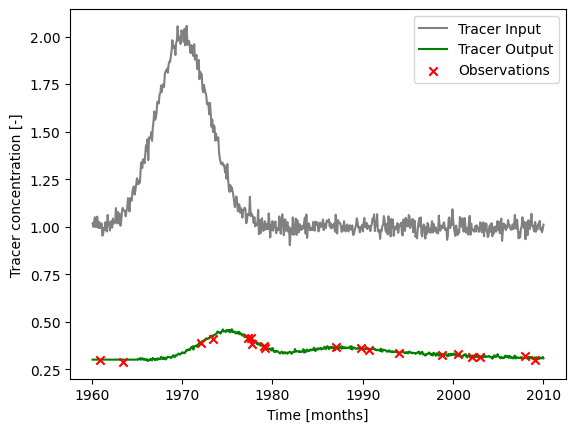

In [46]:
### plot input series, output series, and observations

# get observation timesteps
timesteps = [t.year + t.month / 12.0 for t in timestamps]

# create figure
fig, ax = plt.subplots(1, 1)
# plot input series
ax.plot(
    timesteps,
    input_series,
    label="Tracer Input",
    c="grey"
)
# plot output series
ax.plot(
    timesteps,
    output_series,
    label="Tracer Output",
    c="green"
)
# plot observations
ax.scatter(
    timesteps,
    obs_series,
    label="Observations",
    color="red",
    marker="x",
    zorder=10
)
ax.set_xlabel("Time [months]")
ax.set_ylabel("Tracer concentration [-]")
ax.legend()
plt.show()

## 2. Run MCMC for Model Parameters

In [14]:
t_half = 12.3 * 12.0
lambda_ = np.log(2.0) / t_half

### define model (use the same structure / units as the true model)
# time step is 1 month
m = ism.Model(
    dt=1.0,
    lambda_=lambda_,
    input_series=input_series,
    target_series=obs_series,
    steady_state_input=1., # this is the true value
    n_warmup_half_lives=10
)

# add an exponential-piston-flow unit
# define the initial model parameters for inference
epm_mtt_init = 12 * 1 # 1 year
epm_eta_init = 1.1
m.add_unit(
    ism.EPMUnit(mtt=epm_mtt_init, eta=epm_eta_init),
    fraction=.8, # 80 percent of the overall response; is the true value
    bounds=[(1.0, 12.0 * 50.), (1.0, 3.0)],
    prefix="epm"
)

# add a piston-flow unit
# define the true model parameters
pm_mtt_init = 12 * 1 # 1 year
m.add_unit(
    ism.PMUnit(mtt=pm_mtt_init),
    fraction=.2, # 20 percent of the overall response, is the true value
    bounds=[(1.0, 12.0 * 50.)],
    prefix="pm"
)

In [37]:
# create a solver
solver = ism.Solver(m)
# run MCMC
res = solver.mcmc_sample(
    n_samples=20000, # effective samples after burn-in and thinning
    burn_in=5000,
    thin=2,
    rw_scale=0.05, # 5 percent of the domain width of parameters
    sigma=0.01,
    random_state=42,
    return_sim=True,
    set_model_state=False
)

In [ ]:
# print order of parameters in results dictionary
print(res["param_names"])

['epm.eta', 'epm.mtt', 'pm.mtt']


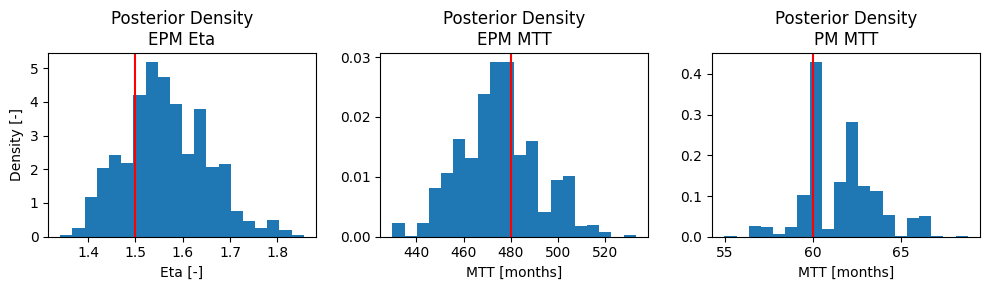

In [50]:
# define true parameters
epm_mtt_true = 12 * 40 # 40 years
epm_eta_true = 1.5
pm_mtt_true = 12 * 5 # 5 years (faster than EPM)

fig, ax = plt.subplots(1, 3, figsize=(10, 3))

_ = ax[0].hist(
    res["samples"][:, 0],
    bins=20,
    density=True,
    label="EPM Eta"
)
ax[0].axvline(epm_eta_true, color="red", label="True")
ax[0].set_title("Posterior Density\nEPM Eta")
ax[0].set_xlabel("Eta [-]")
ax[0].set_ylabel("Density [-]")

_ = ax[1].hist(
    res["samples"][:, 1],
    bins=20,
    density=True,
    label="EPM MTT"
)
ax[1].axvline(epm_mtt_true, color="red", label="True")
ax[1].set_title("Posterior Density\nEPM MTT")
ax[1].set_xlabel("MTT [months]")

_ = ax[2].hist(
    res["samples"][:, 2],
    bins=20,
    density=True,
    label="PM MTT"
)
ax[2].axvline(pm_mtt_true, color="red", label="True")
ax[2].set_title("Posterior Density\nPM MTT")
ax[2].set_xlabel("MTT [months]")

plt.tight_layout()

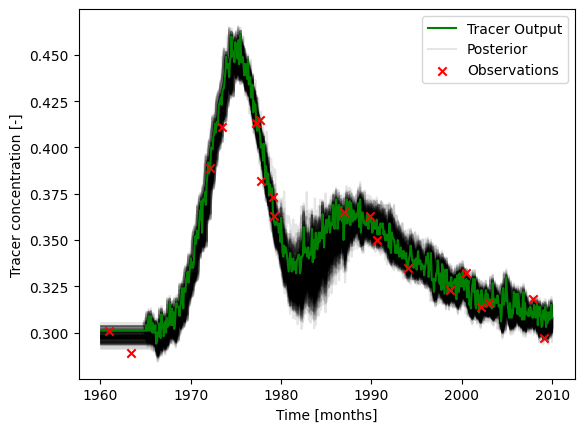

In [ ]:
### plot input series, true output series, observations, and´
# calibrated output

# create figure
fig, ax = plt.subplots(1, 1)
# plot output series
ax.plot(
    timesteps,
    output_series,
    label="Tracer Output",
    c="green",
    zorder=1000000
)
# plot calibrated results
sims_ = res["sims"][::100, :]
for i in range(len(sims_)):
    if i < len(sims_) - 1:
        ax.plot(
            timesteps,
            sims_[i, :],
            # label="Calibration",
            c="black",
            alpha=0.1
        )
    else:
        ax.plot(
            timesteps,
            sims_[i, :],
            label="Posterior Samples",
            c="black",
            alpha=0.1
        )
# plot observations
ax.scatter(
    timesteps,
    obs_series,
    label="Observations",
    color="red",
    marker="x",
    zorder=100000000
)
ax.set_xlabel("Time [months]")
ax.set_ylabel("Tracer concentration [-]")
ax.legend()
plt.show()